# TelecomX - Modelo para previnir evasão

## Blibiotecas

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score, accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, KFold, cross_validate
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from category_encoders import TargetEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline
import seaborn as sns

## Importação dados

In [41]:
dados = pd.read_csv('Dados.csv')
dados['Charges.Total'] = dados['Charges.Total'].replace(r'^\s*$', 0, regex=True)
dados['Charges.Total'] = dados['Charges.Total'].astype("float64")
dados = dados[~dados['Churn'].isna() & (dados['Churn'] != 'nan')]
dados = dados.drop(columns=['Unnamed: 0', 'PaperlessBilling'])
dados = dados[~dados['Churn'].isna() & (dados['Churn'] != 'nan')]


In [42]:
dados_numericos = dados.select_dtypes(include=['number', 'bool'])
correlacao = dados_numericos.corr().abs()
correlacao

,SeniorCitizen,tenure,Charges.Monthly,Charges.Total
SeniorCitizen,1.000000,0.016567,0.220173,0.103006
tenure,0.016567,1.000000,0.247900,0.826178
Charges.Monthly,0.220173,0.247900,1.000000,0.651174
Charges.Total,0.103006,0.826178,0.651174,1.000000


### Tratamento

In [43]:
variaveis = [
    'MultipleLines',
    'InternetService',
    'OnlineSecurity',
    'OnlineBackup',
    'DeviceProtection',
    'TechSupport',
    'StreamingTV',
    'StreamingMovies'
]

for coluna in variaveis:
    print(f"\nFrequência de valores em: {coluna}")
    print(dados[coluna].value_counts())



Frequência de valores em: MultipleLines
MultipleLines
No                  3390
Yes                 2971
No phone service     682
Name: count, dtype: int64

Frequência de valores em: InternetService
InternetService
Fiber optic    3096
DSL            2421
No             1526
Name: count, dtype: int64

Frequência de valores em: OnlineSecurity
OnlineSecurity
No                     3498
Yes                    2019
No internet service    1526
Name: count, dtype: int64

Frequência de valores em: OnlineBackup
OnlineBackup
No                     3088
Yes                    2429
No internet service    1526
Name: count, dtype: int64

Frequência de valores em: DeviceProtection
DeviceProtection
No                     3095
Yes                    2422
No internet service    1526
Name: count, dtype: int64

Frequência de valores em: TechSupport
TechSupport
No                     3473
Yes                    2044
No internet service    1526
Name: count, dtype: int64

Frequência de valores em: StreamingT

In [44]:
variaveis = [
    'PaymentMethod'

]

for coluna in variaveis:
    print(f"\nFrequência de valores em: {coluna}")
    print(dados[coluna].value_counts())


Frequência de valores em: PaymentMethod
PaymentMethod
Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: count, dtype: int64


In [45]:
dadost = dados.copy()

In [46]:
dados_numericos = dadost.select_dtypes(include=['number', 'bool'])
dados_numericos.corr()

,SeniorCitizen,tenure,Charges.Monthly,Charges.Total
SeniorCitizen,1.000000,0.016567,0.220173,0.103006
tenure,0.016567,1.000000,0.247900,0.826178
Charges.Monthly,0.220173,0.247900,1.000000,0.651174
Charges.Total,0.103006,0.826178,0.651174,1.000000


## Encording - Pipeline

In [47]:
dadost.columns

Index(['Churn', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'Contract', 'PaymentMethod', 'Charges.Monthly', 'Charges.Total',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies'],
      dtype='object')

In [48]:
transformer = make_column_transformer(
    # Codificação categórica com TargetEncoder
    (OneHotEncoder(), ['gender', 'Partner', 'Dependents', 'Contract',
                       'PaymentMethod', 'PhoneService', 'MultipleLines',
                       'InternetService', 'OnlineSecurity', 'OnlineBackup',
                       'DeviceProtection', 'TechSupport', 'StreamingTV',
                       'StreamingMovies', 'SeniorCitizen']),
    
    # Padronização das variáveis numéricas
    (StandardScaler(), ['tenure', 'Charges.Monthly', 'Charges.Total']),
)
label_encoder = LabelEncoder()

In [49]:
x = dadost.drop(columns="Churn")
y = dadost['Churn']
y = label_encoder.fit_transform(y)
x = transformer.fit_transform(x)


In [50]:
encoder = transformer.named_transformers_['onehotencoder']  # se tiver nomeado
# ou, se não tiver nomeado, usa o índice (geralmente o primeiro):
encoder = transformer.transformers_[0][1]
nomes_onehot = encoder.get_feature_names_out(['gender', 'Partner', 'Dependents', 'Contract',
                                               'PaymentMethod', 'PhoneService', 'MultipleLines',
                                               'InternetService', 'OnlineSecurity', 'OnlineBackup',
                                               'DeviceProtection', 'TechSupport', 'StreamingTV',
                                               'StreamingMovies', 'SeniorCitizen'])
df_transformado = pd.DataFrame(x, columns=nomes_onehot.tolist() + ['tenure', 'Charges.Monthly', 'Charges.Total'])




## Modelo

### Metricas - **Recall (Revocação)**, **Precisão**, **F1-Score**

In [51]:
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=42)
# Importando o modelo
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(random_state=42, solver='liblinear')


# Treinar o modelo com os dados de treino
print("Treinando o modelo de Regressão Logística com solver 'liblinear'...")
log_reg.fit(X_train, y_train)
print("Treinamento concluído!")

# Fazer previsões com os dados de teste
y_pred_log_reg = log_reg.predict(X_test)

Treinando o modelo de Regressão Logística com solver 'liblinear'...
Treinamento concluído!


In [52]:
# Importando o modelo
from sklearn.ensemble import RandomForestClassifier

# Instanciar o modelo
# n_estimators é o número de árvores na floresta
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)


# Treinar o modelo com os mesmos dados de treino
print("\nTreinando o modelo de Random Forest...")
rf_clf.fit(X_train, y_train)
print("Treinamento concluído!")

# Fazer previsões com os dados de teste
y_pred_rf = rf_clf.predict(X_test)


Treinando o modelo de Random Forest...
Treinamento concluído!


In [53]:
# Importando o modelo
from sklearn.tree import DecisionTreeClassifier

# Instanciar o modelo
# n_estimators é o número de árvores na floresta
arvore = DecisionTreeClassifier(random_state=42, max_depth=10)


# Treinar o modelo com os mesmos dados de treino
print("\nTreinando o modelo de Random Forest...")
arvore.fit(X_train, y_train)
print("Treinamento concluído!")

# Fazer previsões com os dados de teste
y_pred_arvore = arvore.predict(X_test)


Treinando o modelo de Random Forest...
Treinamento concluído!


# Avaliação do modelo

In [54]:
def confusao(y, y_pred, i):
    matriz = confusion_matrix(y, y_pred)
    # Visualizar com heatmap
    sns.heatmap(matriz, annot=True, fmt='d', cmap='Greens',
        xticklabels = ['VN', 'FP'],
        yticklabels = ['FN', 'VF']      
        )
    plt.title(f'Matriz de Confusão da {i}')
    plt.show()
    
def gerar_metricas(nome, modelo, X_test, y_test, y_pred):
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
    cm = confusion_matrix(y_test, y_pred)
    cm_str = f"[[{cm[0][0]}, {cm[0][1]}], [{cm[1][0]}, {cm[1][1]}]]"

    return {
        'Modelo': nome,
        'Acurácia': accuracy_score(y_test, y_pred),
        'Precisão': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'Matriz de Confusão': cm_str
    }


resultados = [
    gerar_metricas("Regressão Logística", log_reg, X_test, y_test, y_pred_log_reg),
    gerar_metricas("Random Forest", rf_clf, X_test, y_test, y_pred_rf),
    gerar_metricas("Árvore de Decisão", arvore, X_test, y_test, y_pred_arvore)
]
# Criar DataFrame
resultados = pd.DataFrame(resultados)
resultados = resultados.sort_values(by='F1-Score', ascending=False)

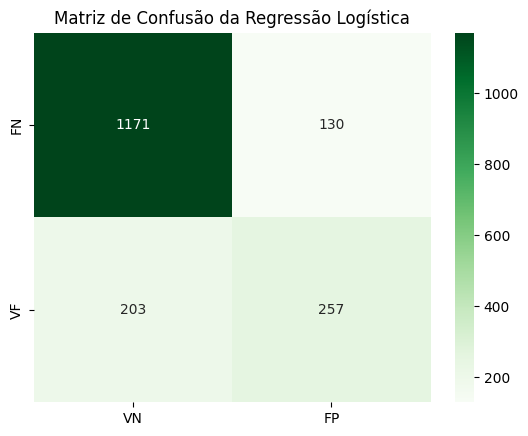

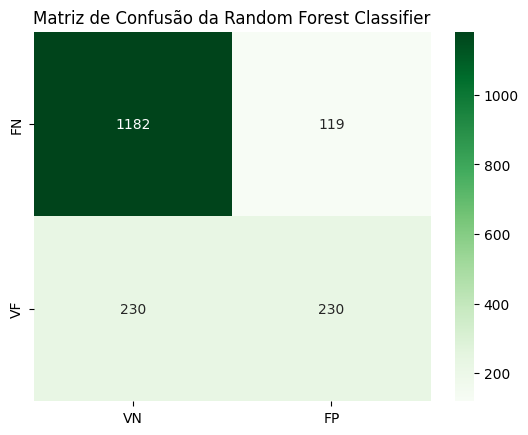

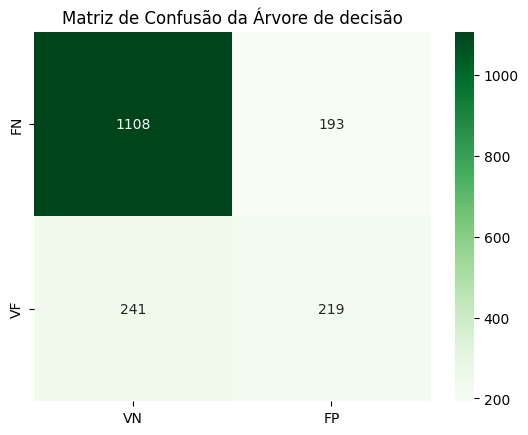

,Modelo,Acurácia,Precisão,Recall,F1-Score,Matriz de Confusão
0,Regressão Logística,0.810903,0.664083,0.558696,0.606848,"[[1171, 130], [203, 257]]"
1,Random Forest,0.801817,0.659026,0.500000,0.568603,"[[1182, 119], [230, 230]]"
2,Árvore de Decisão,0.753549,0.531553,0.476087,0.502294,"[[1108, 193], [241, 219]]"


In [55]:
confusao(y_test, y_pred_log_reg, "Regressão Logística")
confusao(y_test, y_pred_rf, "Random Forest Classifier")
confusao(y_test, y_pred_arvore, "Árvore de decisão")
resultados

In [56]:
coeficientes = pd.DataFrame({
    'Variável': df_transformado.columns,
    'Importância': log_reg.coef_[0]
}).sort_values(by='Importância', ascending=False)
coeficientes_top4 = coeficientes.head(4)
coeficientes_top4



,Variável,Importância
43,Charges.Total,0.749945
6,Contract_Month-to-month,0.671095
19,InternetService_Fiber optic,0.405166
11,PaymentMethod_Electronic check,0.220159


##  Modelo escolhido: **Regressão Logística**

### Justificativa

O modelo de **Regressão Logística** apresentou o melhor equilíbrio entre todas as métricas principais:

- **Acurácia:** 0.81  
- **Precisão:** 0.66  
- **Recall:** 0.56  
- **F1-Score:** 0.61  

Esses resultados indicam que o modelo tem boa capacidade de identificar corretamente os casos de evasão (recall), sem comprometer demais a precisão e o desempenho geral. Além disso, seu comportamento é interpretável, permitindo identificar os principais fatores que influenciam a evasão.

---

##  Principais Variáveis para Regressão Logística

A seguir, as variáveis que mais impactaram nas previsões de evasão segundo a análise de importância:

| Variável                         | Importância |
|----------------------------------|-------------|
| Charges.Total                    | 0.749945    |
| Contract_Month-to-month          | 0.671095    |
| InternetService_Fiber optic      | 0.405166    |
| PaymentMethod_Electronic check   | 0.220159    |

Essas variáveis indicam que clientes com contratos mensais, alto valor total de cobrança, internet via fibra óptica e pagamento via débito eletrônico são mais propensos à evasão. Essas informações são valiosas para criar campanhas de retenção direcionadas.

---

##  Comparações entre Modelos

-  **Random Forest**: Boa acurácia (**80,18%**), mas **Recall (50%)** abaixo do ideal, o que reduz sua efetividade para detectar clientes evadidos.
-  **Árvore de Decisão**: Desempenho inferior nas quatro métricas principais, com destaque negativo para o **Recall (47,61%)** e **F1-Score (50,22%)**.

---

## 📢Conclusão

A **Regressão Logística** se manteve como a melhor escolha, oferecendo o melhor desempenho geral e insights interpretáveis sobre as variáveis mais influentes na evasão. Essa escolha permite combinar alta acurácia com compreensão clara dos fatores que afetam o comportamento do cliente — um diferencial estratégico para retenção.
